In [1]:
# Libraries

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from google.colab import drive
from scipy.stats import norm
from datetime import datetime


drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Fonctions

def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
def bS_delta(S0, K, T,r,sigma):
    d1 = (math.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    delta = norm.cdf(d1)
    return delta
def bS_gamma(S0, K, T, r, sigma):
    d1 = (math.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    gamma = norm.pdf(d1) / (S0 * sigma * math.sqrt(T))
    return gamma
def calculate_greeks(stockPrice, strike, mat, risk_free_rate, volatility):
    delta = bS_delta(stockPrice, strike, mat, risk_free_rate, volatility)
    gamma = bS_gamma(stockPrice, strike, mat, risk_free_rate, volatility)
    return delta, gamma

def Newton2(f,xzero,prix,S,T,K,r,eps=0.0001,niter_max=15,h=0.01):
    x = xzero - f(xzero,prix,S,T,K,r)/((f(xzero+h,prix,S,T,K,r)-f(xzero,prix,S,T,K,r))/h)
    convergence = False
    nb_iteration = 0
    while abs(f(x,prix,S,T,K,r))>eps and nb_iteration <niter_max:
        nb_iteration +=1
        x = x - f(x,prix,S,T,K,r)/((f(x+h,prix,S,T,K,r)-f(x,prix,S,T,K,r))/h)

        if f(x,prix,S,T,K,r)<eps:
            convergence = True
    return x

def dichotomie(f,a,b,prix,S,T,K,r,eps=0.001,n=250):
    "f continue f(a)<0<f(b)"
    iteration=0
    if f(a,prix,S,T,K,r)*f(b,prix,S,T,K,r)>0 :
        return ValueError("Il faut modifier le premier point de sorte que son image soit négative")
    if f(a,prix,S,T,K,r)>f(b,prix,S,T,K,r):
        a,b=b,a
    while b-a>eps and iteration<=n:
        iteration+=1
        c=(a+b)/2
        if f(c,prix,S,T,K,r)>0:
            b=c
        else:
            a=c
    return (a+b)/2

def fct_ecart(sigma,prix,S0,T,K,r): # la variable prix correspond au prix d'un call européen
    return black_scholes_call(S0,K,T,r,sigma)-prix



In [3]:
df = pd.read_excel('drive/MyDrive/vinci/Calibration/Donnees_TD3.xlsx')
df.columns = ['Date', 'Prix action', 'Prix option strike 6', 'Prix option strike 6,5']

In [4]:
df1 = df.iloc[2:]
df1.head()

,Date,Prix action,Prix option strike 6,"Prix option strike 6,5"
2,2017-10-02 00:00:00,6.742,NaN,NaN
3,2017-10-03 00:00:00,6.955,NaN,NaN
4,2017-10-04 00:00:00,6.91,1.02096,0.59093
5,2017-10-05 00:00:00,7.006,1.09932,0.65885
6,2017-10-06 00:00:00,7,1.09306,0.6544


<Axes: >

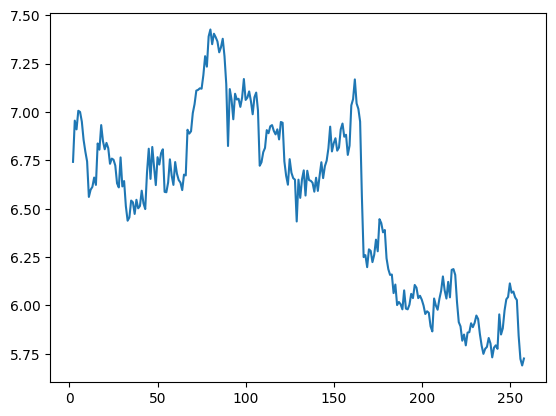

In [5]:
df1['Prix action'].plot()

**Question 1**:
A partir des données fournies (historique d’une action, colonne B), créez l’historique du portefeuille
de réplication d’un call européen de maturité le 31/12/2018, de strike 6 et de volatilité constante égale
à 20%. Ce portefeuille de réplication a-t-il toujours la valeur de l’option ? Pourquoi ?

In [6]:
portfolio = pd.DataFrame(columns=['Call Price', 'Quantite Actions', 'Valeur poche Action','Valeur ZC','Valeur portefeuille'])
date2 = datetime(2018, 12, 31)

for i in range(len(df1['Prix action'])):

    stockPrice = df1['Prix action'].iloc[i]
    cdate =df1['Date'].iloc[i]
    mat = (date2-cdate).days /365
    priceCall = black_scholes_call(stockPrice,6,mat,0,0.2)

    if i == 0:
      delta = bS_delta(stockPrice,6,mat,0,0.2)
      portfoliovalue = priceCall
      zc_value = portfoliovalue  - delta*stockPrice
      portfolio.loc[i] = [priceCall, delta, delta*stockPrice,zc_value, portfoliovalue]
    else:
      portfoliovalue += delta*(stockPrice-df1['Prix action'].iloc[i-1])
      delta = bS_delta(stockPrice,6,mat,0,0.2)
      zc_value =portfoliovalue-delta*stockPrice
      portfolio.loc[i] = [priceCall, delta, delta*stockPrice,zc_value, portfoliovalue]

print(portfolio)


     Call Price  Quantite Actions  Valeur poche Action  Valeur ZC  \
0      1.012460          0.736896             4.968151  -3.955691   
1      1.173632          0.780447             5.428007  -4.258588   
2      1.138193          0.771918             5.333951  -4.199652   
3      1.212687          0.790382             5.537416  -4.329013   
4      1.207450          0.789458             5.526206  -4.322546   
..          ...               ...                  ...        ...   
252    0.258953          0.538497             3.246058  -3.023389   
253    0.169706          0.417298             2.438692  -2.315106   
254    0.120900          0.336647             1.926968  -1.853458   
255    0.108709          0.314013             1.786734  -1.724670   
256    0.119268          0.335814             1.922872  -1.849503   

     Valeur portefeuille  
0               1.012460  
1               1.169419  
2               1.134298  
3               1.208403  
4               1.203660  
..       

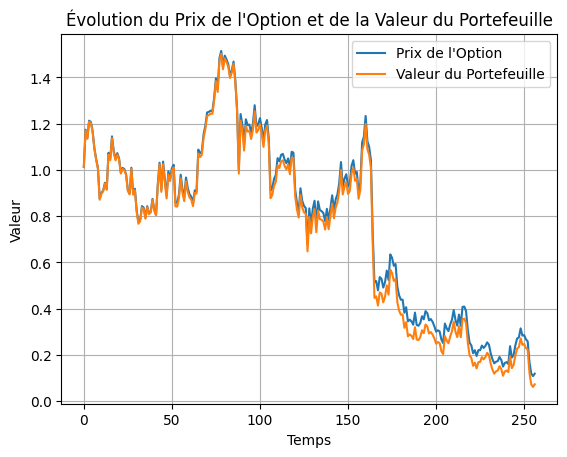

In [7]:
fig, ax = plt.subplots()

ax.plot(portfolio['Call Price'], label='Prix de l\'Option')
ax.plot(portfolio['Valeur portefeuille'], label='Valeur du Portefeuille')

ax.set_title('Évolution du Prix de l\'Option et de la Valeur du Portefeuille')
ax.set_xlabel('Temps')
ax.set_ylabel('Valeur')

ax.legend()
ax.grid(True)
plt.show()


La représentation graphique ci-dessus nous montre que ......

**Question 2 :** On suppose qu’on dispose en plus d’une autre option de mêmes caractéristiques (en particulier une
volatilité de 20%), sinon le strike qui vaut 6.5. On se propose de répliquer notre option initiale en delta
et en gamma. Comment procéder ? Ce nouveau portefeuille de réplication a-t-il toujours la valeur de
l’option ?

In [8]:
portfolio1 = pd.DataFrame(columns =['Call Price','Quantite actions','Quantite option','Valeur poche Action','Valeur poche option', 'Valeur Zc','Valeur Portefeuille'])

for i in range(len(df1['Prix action'])):
    stockPrice = df1['Prix action'].iloc[i]
    cdate = df1['Date'].iloc[i]
    mat = (date2 - cdate).days / 365

    # Calcul des valeurs d'option pour deux strikes différents
    priceCall = black_scholes_call(stockPrice, 6, mat, 0, 0.2)
    priceCall2 = black_scholes_call(stockPrice, 6.5, mat, 0, 0.2)

    if i == 0:
        portfolioValue = priceCall
    else:
        matAsofyersterday = (date2 - df1['Date'].iloc[i-1]).days / 365
        portfolioValue += delta * (stockPrice - df1['Prix action'].iloc[i-1]) + quantOption * (priceCall2 - black_scholes_call(df1['Prix action'].iloc[i-1], 6.5, matAsofyersterday, 0, 0.2))

    delta1, gamma1 = calculate_greeks(stockPrice, 6, mat, 0, 0.2)
    delta2, gamma2 = calculate_greeks(stockPrice, 6.5, mat, 0, 0.2)

    quantOption = gamma1 / gamma2
    delta = delta1 - delta2 * quantOption
    val_poche_action = delta * stockPrice
    val_poche_option = priceCall2 * quantOption
    val_poche_zc = portfolioValue - val_poche_action -  val_poche_option

    # Ajout des résultats au DataFrame
    portfolio1.loc[i] = [priceCall, delta, quantOption,val_poche_action, val_poche_option, val_poche_zc, portfolioValue]

# Affichage du portefeuille
print(portfolio1)

     Call Price  Quantite actions  Quantite option  Valeur poche Action  \
0      1.012460          0.219911         0.849638             1.482638   
1      1.173632          0.246492         0.807950             1.714354   
2      1.138193          0.241243         0.816138             1.666988   
3      1.212687          0.253456         0.797855             1.775712   
4      1.207450          0.253047         0.798634             1.771330   
..          ...               ...              ...                  ...   
252    0.258953          0.228573         1.260968             1.377839   
253    0.169706          0.161017         1.609050             0.940982   
254    0.120900          0.122769         1.933187             0.702727   
255    0.108709          0.112719         2.044774             0.641371   
256    0.119268          0.123297         1.958179             0.706001   

     Valeur poche option  Valeur Zc  Valeur Portefeuille  
0               0.609562  -1.079740     

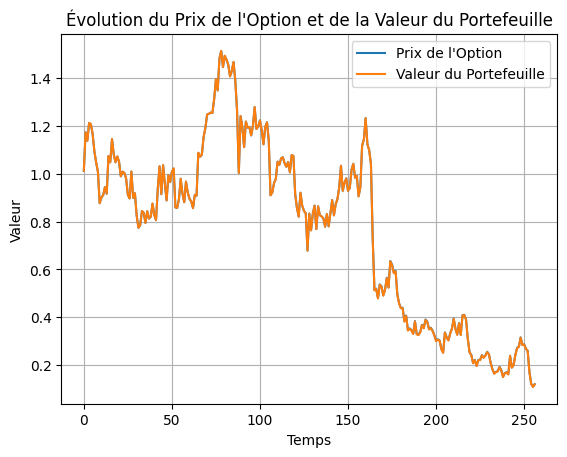

In [9]:
fig, ax = plt.subplots()

ax.plot(portfolio1['Call Price'], label='Prix de l\'Option')
ax.plot(portfolio1['Valeur Portefeuille'], label='Valeur du Portefeuille')

ax.set_title('Évolution du Prix de l\'Option et de la Valeur du Portefeuille')
ax.set_xlabel('Temps')
ax.set_ylabel('Valeur')

ax.legend()
ax.grid(True)
plt.show()

Le graphique ci-contre

**Question 3 :** Représenter le prix d’un call européen en fonction du paramètre de volatilité et calibrer la volatilité
implicite en utilisant l’algorithme de Newton-Raphson puis l’algorithme de dichotomie.

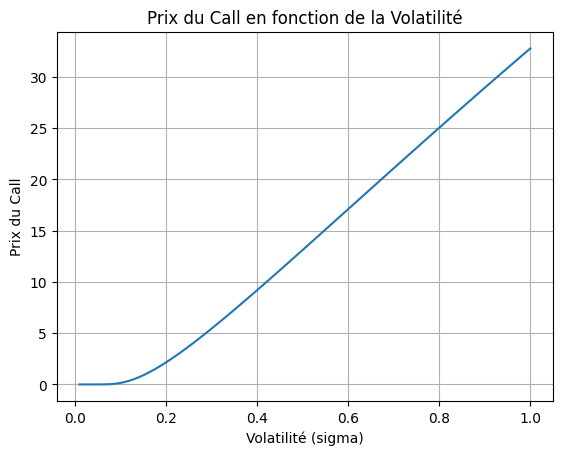

In [10]:
sigmas = np.linspace(0.01, 1.0, 100)
S0 = 100
K = 120
T = 1
r = 0
# Calcul des prix des calls pour chaque volatilité
call_prices = [black_scholes_call(S0, K, T, r, sigma) for sigma in sigmas]

# Tracé du graphique
plt.plot(sigmas, call_prices)
plt.title('Prix du Call en fonction de la Volatilité')
plt.xlabel('Volatilité (sigma)')
plt.ylabel('Prix du Call')
plt.grid(True)
plt.show()

**Newton-Raphson & Dichotomie :**

In [11]:
#Tests
prix=4.214
print("Prix du call européen à trouver :" ,prix)

S0=10
K=6
T=1
r=0

print("Test avec la méthode de Newton-Raphson")
sigmaNR = Newton2(fct_ecart,0.2,prix,S0,T,K,r)
print('vol implicite', sigmaNR)
prixcallNR =round(black_scholes_call(S0,K,T,r,sigmaNR),3)
print("Prix du call européen",prixcallNR)


print(" \n Test avec la méthode de la Dichotomie")
a=0.001
b=10
sigmaD= dichotomie(fct_ecart,a,b,prix,S0,T,K,r)
print('vol implicite',sigmaD)
prixcallD = round(black_scholes_call(S0,K,T,r,sigmaD),3)
print("Prix du call européen",prixcallD)


Prix du call européen à trouver : 4.214
Test avec la méthode de Newton-Raphson
vol implicite 0.4466622823328612
Prix du call européen 4.214
 
 Test avec la méthode de la Dichotomie
vol implicite 0.4468172302246093
Prix du call européen 4.214


**Question 4 :** Estimer l’historique de volatilité implicite pour les deux options dont on a l’historique de prix
(colonnes C et D).

In [12]:
#Création du dataframe contenant les prix et les volatilités implicites de strike 6 et 6.5
df_q4=pd.DataFrame(index=df1['Date'][2:],columns=['Prix action','Prix option strike 6','vol implicite option strike 6 Newton-Raphson','vol implicite option strike 6 Dichotomie','Prix option strike 6.5','vol implicite option strike 6.5 Newton-Raphson','vol implicite option strike 6.5 Dichotomie'])

#paramètres
maturite = datetime(2018,12,31)
nombre_jours_par_an=365.25
K=6
Kbis=6.5
r=0

for i in range(len(df_q4.index)):
    nb_jours=maturite-df_q4.index[i]
    Temps=nb_jours.days/nombre_jours_par_an
    df_q4.iloc[i]['Prix action']=df1.iloc[2+i]['Prix action']
    df_q4.iloc[i]['Prix option strike 6']=df1.iloc[2+i]['Prix option strike 6']
    df_q4.iloc[i]['vol implicite option strike 6 Newton-Raphson']=Newton2(fct_ecart,0.2,df_q4.iloc[i]['Prix option strike 6'],df_q4.iloc[i]['Prix action'],Temps,K,r)
    df_q4.iloc[i]['vol implicite option strike 6 Dichotomie']=dichotomie(fct_ecart,0.0001,10,df_q4.iloc[i]['Prix option strike 6'],df_q4.iloc[i]['Prix action'],Temps,K,r)
    df_q4.iloc[i]['Prix option strike 6.5']=df1.iloc[2+i]['Prix option strike 6,5']
    df_q4.iloc[i]['vol implicite option strike 6.5 Newton-Raphson']=Newton2(fct_ecart,0.2,df_q4.iloc[i]['Prix option strike 6.5'],df_q4.iloc[i]['Prix action'],Temps,Kbis,r)
    df_q4.iloc[i]['vol implicite option strike 6.5 Dichotomie']=dichotomie(fct_ecart,0.0001,10,df_q4.iloc[i]['Prix option strike 6.5'],df_q4.iloc[i]['Prix action'],Temps,Kbis,r)

df_q4


,Prix action,Prix option strike 6,vol implicite option strike 6 Newton-Raphson,vol implicite option strike 6 Dichotomie,Prix option strike 6.5,vol implicite option strike 6.5 Newton-Raphson,vol implicite option strike 6.5 Dichotomie
Date,,,,,,,
2017-10-04,6.91,1.02096,0.145913,0.145667,0.59093,0.117028,0.116981
2017-10-05,7.006,1.09932,0.144845,0.145057,0.65885,0.116606,0.116371
2017-10-06,7,1.09306,0.144367,0.144447,0.6544,0.116728,0.116981
2017-10-09,6.95,1.04813,0.143431,0.143226,0.61591,0.116356,0.116371
2017-10-10,6.856,0.96879,0.143012,0.143226,0.54811,0.115804,0.11576
...,...,...,...,...,...,...,...
2018-09-27,6.028,0.37835,0.297878,0.297643,0.26191,0.361532,0.36173
2018-09-28,5.844,0.28498,0.298651,0.298864,0.19737,0.362381,0.36234
2018-10-01,5.724,0.24261,0.312286,0.312292,0.16974,0.37627,0.376378


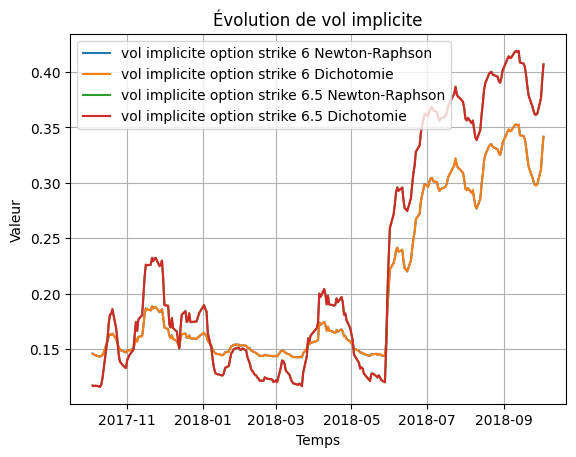

In [13]:
fig, ax = plt.subplots()

ax.plot(df_q4['vol implicite option strike 6 Newton-Raphson'], label='vol implicite option strike 6 Newton-Raphson')
ax.plot(df_q4['vol implicite option strike 6 Dichotomie'], label='vol implicite option strike 6 Dichotomie')
ax.plot(df_q4['vol implicite option strike 6.5 Newton-Raphson'], label='vol implicite option strike 6.5 Newton-Raphson')
ax.plot(df_q4['vol implicite option strike 6.5 Dichotomie'], label='vol implicite option strike 6.5 Dichotomie')

ax.set_title('Évolution de vol implicite')
ax.set_xlabel('Temps')
ax.set_ylabel('Valeur')

ax.legend()
ax.grid(True)
plt.show()

In [23]:
port_vega_hedged=pd.DataFrame(index=df1['Date'][2:],columns=['Prix Call K6','Prix action','Quantite action','poche action','poche ZC','Valeur pft'])

#Initialisation
K=6
r=0
maturite = datetime(2018,12,31)
nb_jours=maturite-port_vega_hedged.index[0]
nombre_jours_par_an=365.25
Temps=nb_jours.days/nombre_jours_par_an

#Première ligne du dataframe
port_vega_hedged.iloc[0]['Prix action']=df1.iloc[2]['Prix action']
port_vega_hedged.iloc[0]['Prix Call K6']=df1.iloc[2]['Prix option strike 6']
port_vega_hedged.iloc[0]['Quantite action']=bS_delta(port_vega_hedged.iloc[0]['Prix action'],K,Temps,r,df_q4.iloc[0]['vol implicite option strike 6 Newton-Raphson'])
port_vega_hedged.iloc[0]['poche action']=port_vega_hedged.iloc[0]['Quantite action']*port_vega_hedged.iloc[0]['Prix action']
port_vega_hedged.iloc[0]['Valeur pft']=port_vega_hedged.iloc[0]['Prix Call K6']
port_vega_hedged.iloc[0]['poche ZC']=port_vega_hedged.iloc[0]['Valeur pft']-port_vega_hedged.iloc[0]['poche action']



In [24]:
#Récurrence
for i in range(1,len(port_vega_hedged.index)):
    nb_jours=maturite-port_vega_hedged.index[i]
    Temps=nb_jours.days/nombre_jours_par_an
    port_vega_hedged.iloc[i]['Prix action']=df1.iloc[i+2]['Prix action']
    port_vega_hedged.iloc[i]['Prix Call K6']=df1.iloc[i+2]['Prix option strike 6']
    port_vega_hedged.iloc[i]['Quantite action']=bS_delta(port_vega_hedged.iloc[i]['Prix action'],K,Temps,r,df_q4.iloc[i]['vol implicite option strike 6 Newton-Raphson'])
    port_vega_hedged.iloc[i]['poche action']=port_vega_hedged.iloc[i]['Quantite action']*port_vega_hedged.iloc[i]['Prix action']
    port_vega_hedged.iloc[i]['Valeur pft']=port_vega_hedged.iloc[i-1]['Valeur pft'] + port_vega_hedged.iloc[i-1]['Quantite action'] * (port_vega_hedged.iloc[i]['Prix action'] - port_vega_hedged.iloc[i-1]['Prix action'])
    port_vega_hedged.iloc[i]['poche ZC']=port_vega_hedged.iloc[i]['Valeur pft']-port_vega_hedged.iloc[i]['poche action']


In [25]:
port_vega_hedged.tail()

,Prix Call K6,Prix action,Quantite action,poche action,poche ZC,Valeur pft
Date,,,,,,
2018-09-27,0.37835,6.028,0.542449,3.269883,-3.20433,0.065552
2018-09-28,0.28498,5.844,0.460916,2.693594,-2.727852,-0.034258
2018-10-01,0.24261,5.724,0.411311,2.354346,-2.443915,-0.089568
2018-10-02,0.24491,5.69,0.403799,2.297614,-2.401167,-0.103553
2018-10-03,0.27191,5.726,0.423515,2.425046,-2.514062,-0.089016


<Figure size 640x480 with 0 Axes>

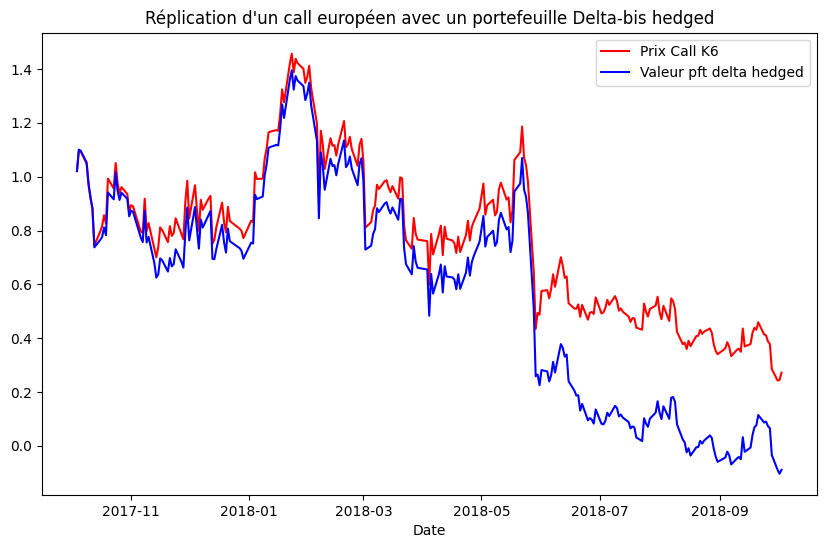

In [26]:
plt.figure(1)
plt.figure(figsize=(10, 6))
plt.plot(port_vega_hedged['Prix Call K6'],c='r')
plt.plot(port_vega_hedged['Valeur pft'],c='b')
plt.xlabel('Date')
plt.legend(["Prix Call K6","Valeur pft delta hedged"])
plt.title("Réplication d'un call européen avec un portefeuille Delta-bis hedged")
plt.show()